# STEP # 2 - TRAIN NEURAL NETWORK. 
## Our goal is to predict patient diagnoses, procedures, services and Rx. In the previous notebook, we only read claims data and prepared the data suitable for training. In this notebook, we train models and perform predictions.

In [1]:
import os
import pandas as pd
import numpy as np
from ConstantsNamespace import PatientJourneyConstantsNamespace

### Constants for file names

In [2]:
constants = PatientJourneyConstantsNamespace()

### Read the saved output of Step # 1 , i.e. 
### (1) input data on 160 features, output data on 160 features, repeat features and new features. All these are one-hot-encoded.
### (2) Read dataframe 'unique_featureids_and_desc'which has metadata of features¶

In [3]:
featureid_id_bubbled_down_x = np.load('step_01_output/featureid_id_bubbled_down_x.npy')
featureid_id_bubbled_down_y = np.load('step_01_output/featureid_id_bubbled_down_y.npy')
repeat_features = np.load('step_01_output/repeat_features.npy')
new_features = np.load('step_01_output/new_features.npy')

unique_featureids_and_desc = pd.read_csv('step_01_output/unique_featureids_and_desc', sep='\t', header=0)

### Verify the feature id for BETA BLOCKERS

In [4]:
unique_featureids_and_desc[unique_featureids_and_desc['Level1']=='BETA BLOCKERS']

,featureid_id,featuretype,Level1
63,63,rx,BETA BLOCKERS


#### Create 'train_data' and 'test_data'. 
#### Create 'train label' and 'test_label' specifically for BETA BLOCKERS 

In [5]:
test_data   = featureid_id_bubbled_down_x[0:1000]
test_labels = new_features[0:1000][:,63] # 63 is for BETA BLOCKERS

train_data   = featureid_id_bubbled_down_x[1000:]
train_labels = new_features[1000:][:,63] # 63 is for BETA BLOCKERS

### Build model

In [6]:
from keras import models, layers

def get_model():
    model = models.Sequential()
    model.add(layers.Dense(160, activation='relu', input_shape=(160,) ))
    model.add(layers.Dense(160, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

2023-08-24 18:23:19.908088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 18:23:19.942257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 18:23:19.943094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 18:23:21.496297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### K-fold Cross-validation 

In [7]:
k = 3
num_val_samples = len(train_data)//k
num_epochs = 10
accuracy_histories = []
loss_histories = []
val_accuracy_histories = []
val_loss_histories = []

model = get_model()

for i in range(k):
    print('Processing fold # ', i)
    val_data   = train_data[ i*num_val_samples : (i+1)*num_val_samples ]
    val_labels = train_labels[ i*num_val_samples : (i+1)*num_val_samples ]

    partial_train_data   = np.concatenate([ train_data[: i* num_val_samples]   , train_data[(i+1)* num_val_samples : ] ] , axis=0)
    partial_train_labels = np.concatenate([ train_labels[: i* num_val_samples] , train_labels[(i+1)* num_val_samples : ] ] , axis=0)

    history = model.fit(partial_train_data, partial_train_labels, validation_data=(val_data, val_labels), epochs=num_epochs)

    accuracy_histories.append(history.history['accuracy'])
    loss_histories.append(history.history['loss'])
    val_accuracy_histories.append(history.history['val_accuracy'])
    val_loss_histories.append(history.history['val_loss'])

Processing fold #  0
Epoch 1/10
4641/4641 [==============================] - 16s 3ms/step - loss: 0.0335 - accuracy: 0.9947 - val_loss: 0.0432 - val_accuracy: 0.9929
Epoch 2/10
4641/4641 [==============================] - 13s 3ms/step - loss: 0.0326 - accuracy: 0.9947 - val_loss: 0.0394 - val_accuracy: 0.9929
Epoch 3/10
4641/4641 [==============================] - 15s 3ms/step - loss: 0.0326 - accuracy: 0.9947 - val_loss: 0.0414 - val_accuracy: 0.9929
Epoch 4/10
4641/4641 [==============================] - 13s 3ms/step - loss: 0.0325 - accuracy: 0.9947 - val_loss: 0.0456 - val_accuracy: 0.9929
Epoch 5/10
4641/4641 [==============================] - 10s 2ms/step - loss: 0.0323 - accuracy: 0.9947 - val_loss: 0.0515 - val_accuracy: 0.9929
Epoch 6/10
4641/4641 [==============================] - 10s 2ms/step - loss: 0.0333 - accuracy: 0.9947 - val_loss: 0.0500 - val_accuracy: 0.9929
Epoch 7/10
4641/4641 [==============================] - 12s 3ms/step - loss: 0.0337 - accuracy: 0.9947 - val_

### Plot training and validation loss

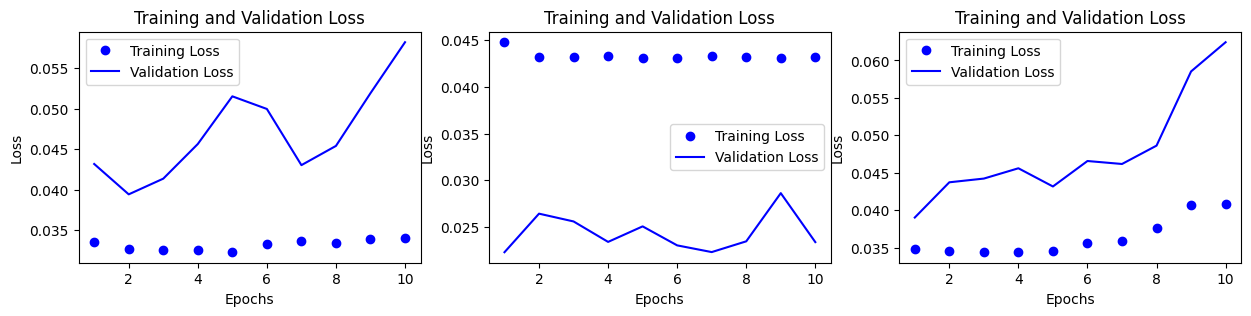

In [8]:
import matplotlib.pyplot as plt

#loss = loss_histories[2]
#val_loss = val_loss_histories[2]

epochs = range(1, len(loss_histories[0])+1)

plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(epochs, loss_histories[0], 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_histories[0], 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(epochs, loss_histories[1], 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_histories[1], 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(133)
plt.plot(epochs, loss_histories[2], 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_histories[2], 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## PREDICT - Evaluate on test data

In [9]:
print(model.metrics_names)

['loss', 'accuracy']


In [10]:
results = model.evaluate(test_data, test_labels)

32/32 [==============================] - 0s 3ms/step - loss: 0.0666 - accuracy: 0.9920


In [11]:
results

[0.06663759052753448, 0.9919999837875366]

## Save the Model

In [12]:
model.save('step_02_output_keras_model/model_to_predict_new_beta_blocker_use.keras')